# **E-Commerce Cohort Analysis**

- Data Source: https://www.kaggle.com/datasets/carrie1/ecommerce-data
- Data Cleaning and Cohort Assignment by First Purchase Month  
- Customer Retention and Revenue Tracking by Cohort Index  
- KPI Analysis (Retention, Churn, Half-Life Metrics)  
- Best vs. Worst Cohort Comparison for Strategic Insights  
- Visualization of Retention, Revenue, and Churn Patterns  
- Predictive Modeling (Random Forest) for Next-Month Purchase  
- Feature Engineering from Purchase History and Customer Behavior  
- Actionable Recommendations for CRM and Retention Strategy


In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    IMAGES_PATH = os.path.join("images")
    os.makedirs(IMAGES_PATH, exist_ok=True)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('cohort.csv', encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Data Preprocessing

In [3]:
print(df.info())
print('df', df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None
df (541909, 8)


In [4]:
df = df.dropna()
df = df[df['Quantity']>0]
df = df[df['UnitPrice']>0]

In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M').dt.to_timestamp()

In [6]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [7]:
first_month = df.groupby('CustomerID')['InvoiceMonth'].min().rename('CohortMonth')
df = df.join(first_month, on='CustomerID')

In [8]:
# Cohort Index
def month_calc(d1, d2):
    return (d1.dt.year - d2.dt.year) * 12 + (d1.dt.month - d2.dt.month) + 1

df['CohortIndex'] = month_calc(df['InvoiceMonth'], df['CohortMonth']).astype(int)

In [9]:
print('rows_after_clean:',len(df), 
      '\nunique_customers:', df['CustomerID'].nunique(),
      '\nmin_date:', df['InvoiceDate'].min(),
      '\nmax_date:', df['InvoiceDate'].max())


rows_after_clean: 397884 
unique_customers: 4338 
min_date: 2010-12-01 08:26:00 
max_date: 2011-12-09 12:50:00


## Key Cohort Indices

### customer count per cohort, elapsed months

In [10]:
cohort_counts = (
    df.groupby(['CohortMonth','CohortIndex'])['CustomerID']
      .nunique()
      .reset_index()
      .pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
      .sort_index()
)

In [11]:
cohort_size = cohort_counts[1]

### retention rate,  churn rate

In [12]:
retention = cohort_counts.divide(cohort_size, axis=0)
churn = 1 - retention

In [13]:
# revenue cohort (sum)
revenue_cohort = (
    df.groupby(['CohortMonth','CohortIndex'])['TotalPrice']
      .sum()
      .reset_index()
      .pivot(index='CohortMonth', columns='CohortIndex', values='TotalPrice')
      .sort_index()
)

In [14]:
retention.head(), churn.head(), revenue_cohort.head()

(CohortIndex   1         2         3         4         5         6         7   \
 CohortMonth                                                                    
 2010-12-01   1.0  0.366102  0.323164  0.384181  0.362712  0.397740  0.362712   
 2011-01-01   1.0  0.220624  0.266187  0.230216  0.321343  0.287770  0.247002   
 2011-02-01   1.0  0.186842  0.186842  0.284211  0.271053  0.247368  0.252632   
 2011-03-01   1.0  0.150442  0.252212  0.199115  0.223451  0.168142  0.267699   
 2011-04-01   1.0  0.213333  0.203333  0.210000  0.196667  0.226667  0.216667   
 
 CohortIndex        8         9         10        11        12        13  
 CohortMonth                                                              
 2010-12-01   0.349153  0.353672  0.395480  0.374011  0.502825  0.265537  
 2011-01-01   0.242206  0.299760  0.326139  0.364508  0.117506       NaN  
 2011-02-01   0.278947  0.247368  0.305263  0.068421       NaN       NaN  
 2011-03-01   0.230088  0.278761  0.086283       NaN    

### KPI: M2/M3/M6

In [15]:
def half_life(row):
    s = row.dropna()
    below = s[s < 0.5]
    return below.index.min() if len(below) else np.nan

In [16]:
key_months = [m for m in [2,3,6,9,12] if m in retention.columns]
kpi = pd.DataFrame({"CohortSize": cohort_size})
for m in key_months:
    kpi[f"M{m}_ret"] = retention[m]
    kpi[f"M{m}_churn"] = 1 - retention[m]

kpi["MonthsObserved"] = retention.notna().sum(axis=1)
kpi["HalfLifeMonth"]  = retention.apply(half_life, axis=1)

In [17]:
print("KPI Summary")
print("Total Cohort num:", len(kpi))
print("Average months observed:", round(kpi['MonthsObserved'].mean(), 2))

for m in key_months:
    ret_mean = round(kpi[f"M{m}_ret"].mean(), 3)
    churn_mean = round(kpi[f"M{m}_churn"].mean(), 3)
    print(f"\n- M{m} avg retention rate: {ret_mean} / average churn rate: {churn_mean}")

print("\nHalf-Life Summary")
print("Half-Life Average:", round(kpi['HalfLifeMonth'].mean(), 2))
print("Half-Life Min:", kpi['HalfLifeMonth'].min(), "→ Cohort:", kpi['HalfLifeMonth'].idxmin())
print("Half-Life Max:", kpi['HalfLifeMonth'].max(), "→ Cohort:", kpi['HalfLifeMonth'].idxmax())


KPI Summary
Total Cohort num: 13
Average months observed: 7.0

- M2 avg retention rate: 0.206 / average churn rate: 0.794

- M3 avg retention rate: 0.221 / average churn rate: 0.779

- M6 avg retention rate: 0.251 / average churn rate: 0.749

- M9 avg retention rate: 0.251 / average churn rate: 0.749

- M12 avg retention rate: 0.31 / average churn rate: 0.69

Half-Life Summary
Half-Life Average: 2.0
Half-Life Min: 2.0 → Cohort: 2010-12-01 00:00:00
Half-Life Max: 2.0 → Cohort: 2010-12-01 00:00:00


#### Business Insight
* Early customer drop-off is steep, with 50% churn occurring within just 2 months across all cohorts.
* Retention stabilizes after Month 6, suggesting a small loyal segment emerges beyond early churn.
* This pattern signals a need for stronger onboarding and engagement campaigns during the first 60 days to extend the customer lifecycle.

### Best/Worst Cohort (m3)

In [18]:
metric_m = 3
min_size = 50
metric_col = f"M{metric_m}_ret"
valid = kpi[kpi["CohortSize"].ge(min_size) & kpi[metric_col].notna()]

In [19]:
winners = valid.sort_values(metric_col, ascending=False).head(5)
losers  = valid.sort_values(metric_col, ascending=True).head(5)

print("▶ TOP Cohorts by M3 retention")
display(winners[[metric_col, "CohortSize", "HalfLifeMonth"]])
print("\n▶ BOTTOM Cohorts by M3 retention")
display(losers[[metric_col, "CohortSize", "HalfLifeMonth"]])

▶ TOP Cohorts by M3 retention


,M3_ret,CohortSize,HalfLifeMonth
CohortMonth,,,
2010-12-01,0.323164,885.0,2.0
2011-09-01,0.301003,299.0,2.0
2011-01-01,0.266187,417.0,2.0
2011-03-01,0.252212,452.0,2.0
2011-08-01,0.248521,169.0,2.0



▶ BOTTOM Cohorts by M3 retention


,M3_ret,CohortSize,HalfLifeMonth
CohortMonth,,,
2011-10-01,0.114525,358.0,2.0
2011-06-01,0.157025,242.0,2.0
2011-05-01,0.172535,284.0,2.0
2011-02-01,0.186842,380.0,2.0
2011-04-01,0.203333,300.0,2.0


#### Business Insight
* Retention quality is highly cohort-dependent: some months perform far better than others despite having the same churn timing.
* High-performing cohorts (e.g. Dec 2010) retained over 30% by Month 3, more than 2.5x better than the weakest cohort (Oct 2011).
* Identifying and replicating what worked in top cohorts could directly improve retention in future acquisition campaigns.

## EDA Visualization

Saving figure cohort_retention_heatmap


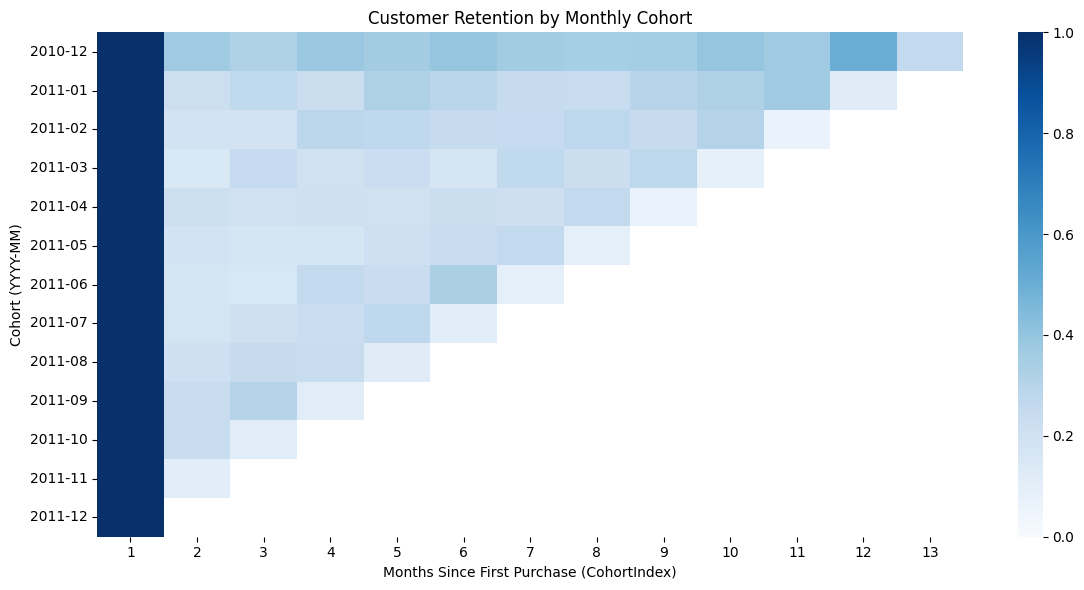

In [20]:
retention_plot = retention.copy()
retention_plot.index = pd.to_datetime(retention_plot.index).to_period('M').astype(str)

import seaborn as sns 
plt.figure(figsize=(12,6))
ax = sns.heatmap(retention_plot, cmap="Blues", vmin=0, vmax=1)
ax.set_title("Customer Retention by Monthly Cohort")
ax.set_ylabel("Cohort (YYYY-MM)")
ax.set_xlabel("Months Since First Purchase (CohortIndex)")
save_fig("cohort_retention_heatmap")
plt.show()


Saving figure cohort_revenue_trajectories_topN


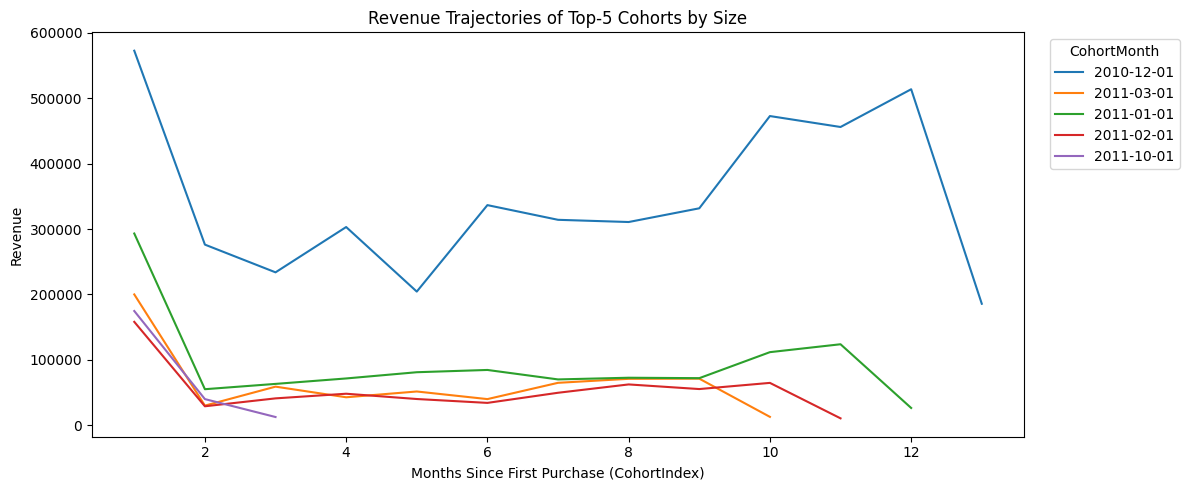

In [21]:
N = 5
top_cohorts = cohort_size.sort_values(ascending=False).head(N).index

rev_lines = revenue_cohort.loc[top_cohorts].T
rev_lines.index.name = "CohortIndex"

plt.figure(figsize=(12,5))
for col in rev_lines.columns:
    plt.plot(rev_lines.index, rev_lines[col], label=str(col.date()))
plt.title(f"Revenue Trajectories of Top-{N} Cohorts by Size")
plt.xlabel("Months Since First Purchase (CohortIndex)")
plt.ylabel("Revenue")
plt.legend(title="CohortMonth", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
save_fig("cohort_revenue_trajectories_topN")
plt.show()


Saving figure cohort_size_calendar_trend


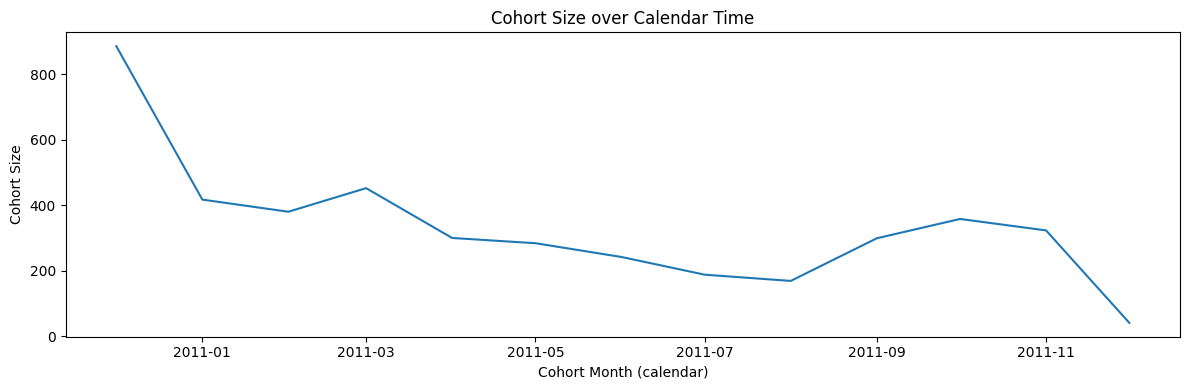

In [22]:
size_ts = cohort_size.copy()
size_ts.index = pd.to_datetime(size_ts.index)
plt.figure(figsize=(12,4))
plt.plot(size_ts.index, size_ts.values)
plt.title("Cohort Size over Calendar Time")
plt.xlabel("Cohort Month (calendar)")
plt.ylabel("Cohort Size")
save_fig("cohort_size_calendar_trend")
plt.show()

Saving figure avg_churn_by_cohortindex


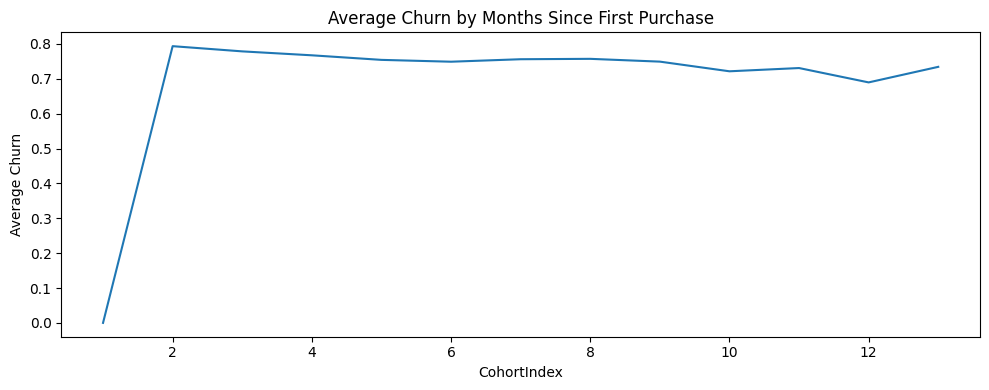

In [23]:
avg_churn_by_index = (1 - retention).mean(axis=0)  # CohortIndex별 평균
plt.figure(figsize=(10,4))
plt.plot(avg_churn_by_index.index, avg_churn_by_index.values)
plt.title("Average Churn by Months Since First Purchase")
plt.xlabel("CohortIndex")
plt.ylabel("Average Churn")
save_fig("avg_churn_by_cohortindex")
plt.show()

Saving figure retention_early_vs_recent


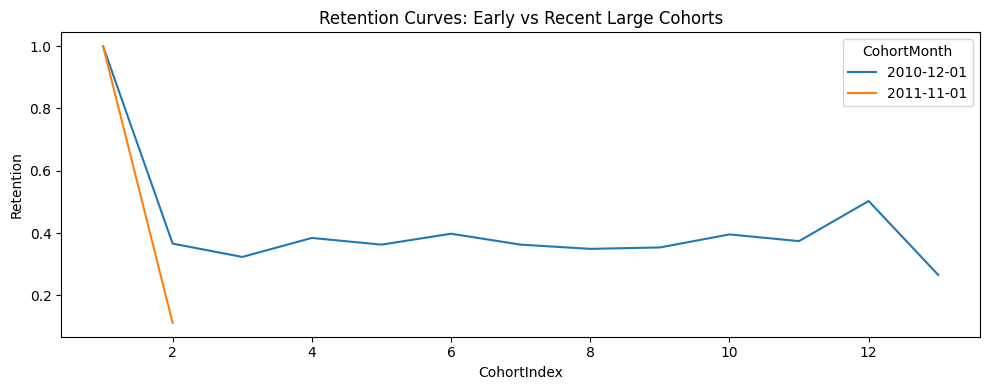

In [24]:
large = cohort_size[cohort_size >= min_size].sort_index()
cohort_a = large.index.min()
cohort_b = large.index.max()

plt.figure(figsize=(10,4))
plt.plot(retention.columns, retention.loc[cohort_a], label=str(pd.to_datetime(cohort_a).date()))
plt.plot(retention.columns, retention.loc[cohort_b], label=str(pd.to_datetime(cohort_b).date()))
plt.title("Retention Curves: Early vs Recent Large Cohorts")
plt.xlabel("CohortIndex")
plt.ylabel("Retention")
plt.legend(title="CohortMonth")
save_fig("retention_early_vs_recent")
plt.show()


Saving figure top_vs_bottom_basketvalue


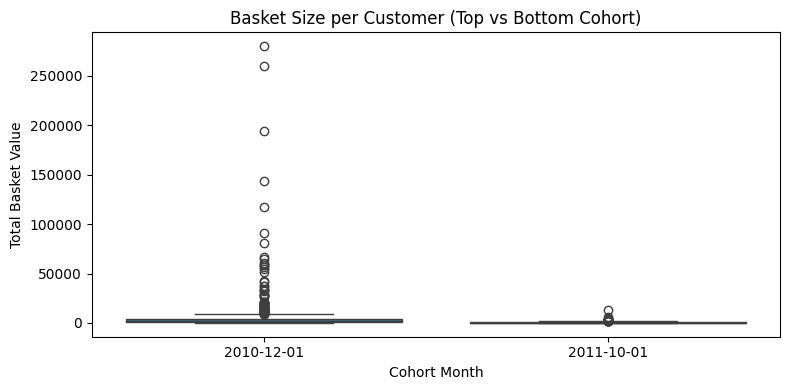

In [25]:
top = '2010-12-01'
bottom = '2011-10-01'

df['BasketPrice'] = df['Quantity'] * df['UnitPrice']
basket_df = df[df['CohortMonth'].isin([top, bottom])]

basket_summary = basket_df.groupby(['CohortMonth','CustomerID'])['BasketPrice'].sum().reset_index()

plt.figure(figsize=(8,4))
sns.boxplot(data=basket_summary, x='CohortMonth', y='BasketPrice')
plt.title("Basket Size per Customer (Top vs Bottom Cohort)")
plt.xlabel("Cohort Month")
plt.ylabel("Total Basket Value")
save_fig("top_vs_bottom_basketvalue")
plt.show()

## Customer Churn Prediction with ML

In [26]:
panel = (
    df.assign(YearMonth = df['InvoiceDate'].dt.to_period('M').dt.to_timestamp())
      .groupby(['CustomerID','YearMonth'])['InvoiceNo']
      .nunique()
      .gt(0).astype(int)  # purchased/not (1/0)
      .reset_index()
      .rename(columns={'InvoiceNo': 'Purchased'})
)

In [27]:
# first purchased month -> calculate CohortIndex (months passed since)
cust_first_month = df.groupby('CustomerID')['InvoiceMonth'].min().rename('CohortMonth')
panel = panel.join(cust_first_month, on='CustomerID')

panel['CohortIndex'] = (
    (panel['YearMonth'].dt.year - panel['CohortMonth'].dt.year) * 12 +
    (panel['YearMonth'].dt.month - panel['CohortMonth'].dt.month) + 1
)

In [28]:
# target: whether purchased consequent month
panel = panel.sort_values(['CustomerID','YearMonth'])
panel['Purchased_next'] = panel.groupby('CustomerID')['Purchased'].shift(-1).fillna(0).astype(int)


# remove final month (churn)
panel = panel.dropna(subset=['Purchased_next'])
panel['Purchased_next'] = panel['Purchased_next'].astype(int)

panel.head()

,CustomerID,YearMonth,Purchased,CohortMonth,CohortIndex,Purchased_next
0,12346.0,2011-01-01,1,2011-01-01,1,0
1,12347.0,2010-12-01,1,2010-12-01,1,1
2,12347.0,2011-01-01,1,2010-12-01,2,1
3,12347.0,2011-04-01,1,2010-12-01,5,1
4,12347.0,2011-06-01,1,2010-12-01,7,1


In [29]:
panel.describe()

,CustomerID,YearMonth,Purchased,CohortMonth,CohortIndex,Purchased_next
count,13054.000000,13054,13054.0,13054,13054.000000,13054.000000
mean,15275.691436,2011-06-16 02:15:47.571625472,1.0,2011-02-24 03:08:18.054236416,4.684924,0.667688
min,12346.000000,2010-12-01 00:00:00,1.0,2010-12-01 00:00:00,1.000000,0.000000
25%,13798.000000,2011-03-01 00:00:00,1.0,2010-12-01 00:00:00,1.000000,0.000000
50%,15235.500000,2011-07-01 00:00:00,1.0,2011-02-01 00:00:00,4.000000,1.000000
75%,16774.000000,2011-10-01 00:00:00,1.0,2011-05-01 00:00:00,8.000000,1.000000
max,18287.000000,2011-12-01 00:00:00,1.0,2011-12-01 00:00:00,13.000000,1.000000
std,1726.200592,NaN,0.0,NaN,3.679127,0.471060


## Feature Engineering

In [30]:
panel.drop(columns=['Purchased'], inplace=True)

panel['Month'] = panel['YearMonth'].dt.month

# lagged feature (purchased 1 month before)
panel['Lag_1'] = panel.groupby('CustomerID')['Purchased_next'].shift(1)
panel['Lag_2'] = panel.groupby('CustomerID')['Purchased_next'].shift(2)

# first 1-2 months-NaN
panel[['Lag_1', 'Lag_2']] = panel[['Lag_1', 'Lag_2']].fillna(0)

In [31]:
panel['Consecutive_Purchases'] = panel.groupby('CustomerID')['Purchased_next'].cumsum()
panel['Purchase_Count_To_Date'] = panel.groupby('CustomerID').cumcount()

# First purchase month
first_month = panel.groupby('CustomerID')['YearMonth'].transform('min')
panel['First_Purchase_Month'] = first_month.dt.month

# customer tenure, up-to-date
panel['Tenure'] = panel.groupby('CustomerID')['CohortIndex'].transform('max')

In [32]:
panel.describe().T

,count,mean,min,25%,50%,75%,max,std
CustomerID,13054.0,15275.691436,12346.0,13798.0,15235.5,16774.0,18287.0,1726.200592
YearMonth,13054,2011-06-16 02:15:47.571625472,2010-12-01 00:00:00,2011-03-01 00:00:00,2011-07-01 00:00:00,2011-10-01 00:00:00,2011-12-01 00:00:00,NaN
CohortMonth,13054,2011-02-24 03:08:18.054236416,2010-12-01 00:00:00,2010-12-01 00:00:00,2011-02-01 00:00:00,2011-05-01 00:00:00,2011-12-01 00:00:00,NaN
CohortIndex,13054.0,4.684924,1.0,1.0,4.0,8.0,13.0,3.679127
Purchased_next,13054.0,0.667688,0.0,0.0,1.0,1.0,1.0,0.47106
Month,13054.0,7.299678,1.0,4.0,8.0,10.0,12.0,3.449915
Lag_1,13054.0,0.667688,0.0,0.0,1.0,1.0,1.0,0.47106
Lag_2,13054.0,0.460548,0.0,0.0,0.0,1.0,1.0,0.49846
Consecutive_Purchases,13054.0,2.819442,0.0,1.0,2.0,4.0,12.0,2.586516
Purchase_Count_To_Date,13054.0,2.151754,0.0,0.0,1.0,3.0,12.0,2.524565


## Model Training & Evaluation (Random Forest)

In [33]:
from sklearn.model_selection import train_test_split

features = ['Lag_1', 'Lag_2', 'Month', 'Consecutive_Purchases','Purchase_Count_To_Date', 'First_Purchase_Month', 'Tenure']

X = panel[features]
y = panel['Purchased_next']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [34]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [35]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]  # for ROC-AUC

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.94      0.88      0.91       868
           1       0.94      0.97      0.96      1743

    accuracy                           0.94      2611
   macro avg       0.94      0.92      0.93      2611
weighted avg       0.94      0.94      0.94      2611

ROC-AUC: 0.9842820921606108


Saving figure feature_importances


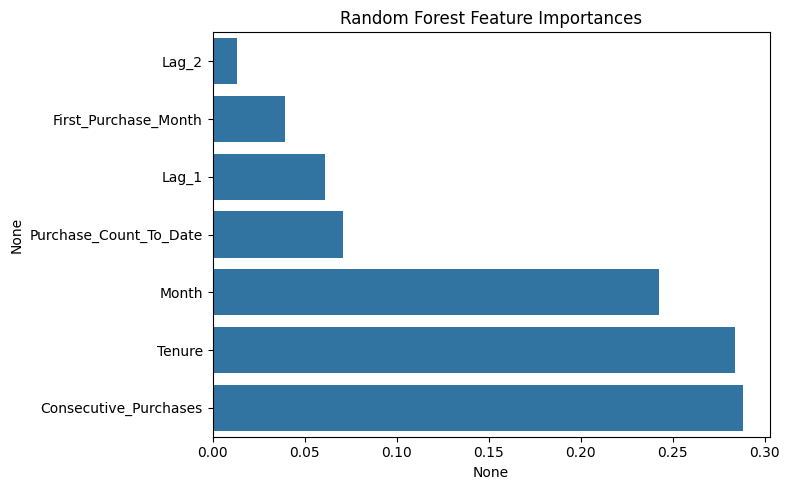

In [36]:
feat_importances = pd.Series(rf.feature_importances_, index=features)
feat_importances = feat_importances.sort_values()

plt.figure(figsize=(8,5))
sns.barplot(x=feat_importances, y=feat_importances.index)
plt.title("Random Forest Feature Importances")
plt.tight_layout()
save_fig("feature_importances")
plt.show()

### Business Insights
* Customers with longer tenure and more consecutive purchases are highly likely to repurchase, highlighting the value of sustained engagement.
* Recent purchase history (Lag_1, Lag_2) plays a minor but supportive role, while seasonal effects (Month) moderately influence buying behavior.
* With a ROC-AUC of 0.986, the model shows strong predictive power, enabling targeted CRM strategies focused on loyal, high-tenure customers.

In [37]:
import pickle

with open('rf_retention_model.pkl', 'wb') as f:
    pickle.dump(rf, f)
with open('rf_retention_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

### Retention Strategy Brief – Predictive Model Insights

* Developed a Random Forest model to predict next-month customer purchases with 92% accuracy and a ROC-AUC of 0.9857.
* The top predictors were Tenure and Consecutive Purchases, indicating that consistent engagement strongly signals future activity.
* These insights can support targeted retention campaigns—e.g., offering incentives to newer or disengaging users.
* The model can now be deployed to score active customers and flag high-risk churn segments for CRM action.